<a href="https://colab.research.google.com/github/as9786/ML-DLPratice/blob/main/DataAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Albumentations

In [3]:
!pip install albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os 
import math
import random

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras import activations

In [7]:
import albumentations as A

class Augmentation: 
    def __init__(self,size,mode='train'):
        # Declare an augementation pipeline
        if mode=='train':
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15
                ),
                A.CoarseDropout(
                    p=0.5,
                    max_holes=8,
                    max_height=int(0.1*size),
                    max_width=int(0.1*size)
                )
                ,A.RandomBrightnessContrast(p=0.2)
            ])
    def __call__(self,**kwargs):
        if self.transform:
            augmented = self.transform(**kwargs)
            img = augmented['image']
            return img


In [11]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self,batch_size,csv_path,fold,image_size,mode='train',shuffle=True):
        self.batch_size = batch_size
        self.fold = fold
        self.mode = mode
        self.image_size = image_size
        self.shuffle = shuffle

        self.df = pd.read_csv(csv_path)

        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]

        invalid_filenames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        self.df = self.df[~self.df['file_name'].isin(invalid_filenames)]

        self.transform = Augmentation(image_size,mode)
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size) # batch_size로 안나눠지는것을 방지하기 위해 올림

    def __getitem__(self,idx):
        strt = idx * self.batch_size
        fin = (idx+1) * self.batch_size
        data = self.df.iloc[strt:fin]

        batch_x, batch_y = self.get_data(data)

        return np.array(batch_x), np.array(batch_y)
    
    def get_data(self,data):

        batch_x = []
        batch_y = []

        for _,r in data.iterrows():
            file_name = r['file_name'] 
            
            image = cv2.imread(f'/content/drive/MyDrive/oxford_pet/images/{file_name}.jpg')
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            
            image = cv2.resize(image,(self.image_size,self.image_size))

            if self.mode == 'train':
                image = image.astype('uint8')
                image = self.transform(image=image)

            image = image.astype('float32')
            image = image / 255.

            label = int(r['species']) - 1

            batch_x.append(image) 
            batch_y.append(label) 

        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [12]:
csv_path = '/content/drive/MyDrive/FastCampus/이미지처리/kfolds.csv'
train_generator = DataGenerator(
    batch_size=128,
    csv_path = csv_path,
    fold=1,
    image_size=256,
    mode='train',
    shuffle = True
)

valid_generator = DataGenerator(
    batch_size=128,
    csv_path = csv_path,
    fold=1,
    image_size=256,
    mode='val',
    shuffle = True
)

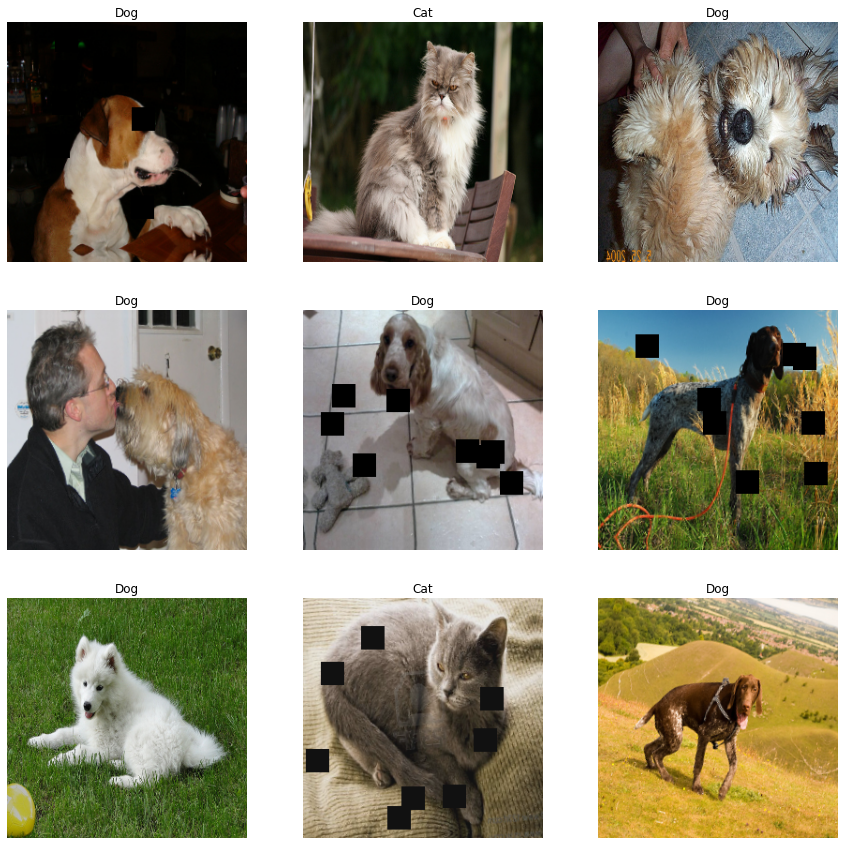

In [13]:
class_names = ['Cat','Dog']

for batch in train_generator:
    X, y = batch
    plt.figure(figsize=(15, 15))

    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(X[i])
        plt.title(class_names[y[i]])
        plt.axis('off')
    break

In [14]:
def get_sequential_model(input_shape):

    model = keras.Sequential(
        [
            #Input
            layers.Input(input_shape),

            # 1st Conv block
            layers.Conv2D(64,3,strides=1,activation='relu',padding='same'),
            layers.Conv2D(64,3,strides=1,activation='relu',padding='same'),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.5),

            # 2nd Conv block
            layers.Conv2D(128,3,strides=1,activation='relu',padding='same'),
            layers.Conv2D(128,3,strides=1,activation='relu',padding='same'),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.3),

            #Classifier
            layers.GlobalMaxPool2D(),
            layers.Dense(128,activation='relu'),
            layers.Dense(1,activation='sigmoid')
        ]
    )

    return model

In [15]:
input_shape = (256,256,3)
model = get_sequential_model(input_shape)

In [16]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs=10,
    verbose=1
)

Epoch 1/10
46/46 [==============================] - 6421s 140s/step - loss: 1.1268 - accuracy: 0.6374 - val_loss: 0.6260 - val_accuracy: 0.6780
Epoch 2/10
46/46 [==============================] - 87s 2s/step - loss: 0.6301 - accuracy: 0.6730 - val_loss: 0.6545 - val_accuracy: 0.6780
Epoch 3/10
46/46 [==============================] - 88s 2s/step - loss: 0.6351 - accuracy: 0.6765 - val_loss: 0.6626 - val_accuracy: 0.6780
Epoch 4/10
46/46 [==============================] - 87s 2s/step - loss: 0.6548 - accuracy: 0.6456 - val_loss: 0.6659 - val_accuracy: 0.6767
Epoch 5/10
46/46 [==============================] - 88s 2s/step - loss: 0.6378 - accuracy: 0.6726 - val_loss: 0.6595 - val_accuracy: 0.6780
Epoch 6/10
46/46 [==============================] - 87s 2s/step - loss: 0.6268 - accuracy: 0.6752 - val_loss: 0.6546 - val_accuracy: 0.6773
Epoch 7/10
46/46 [==============================] - 88s 2s/step - loss: 0.6153 - accuracy: 0.6801 - val_loss: 0.6279 - val_accuracy: 0.6780
Epoch 8/10
46/46